<img
src="https://www.imt-atlantique.fr/sites/default/files/Images/Ecole/charte-graphique/IMT_Atlantique_logo_RVB_Baseline_400x272.jpg"
WIDTH=200 HEIGHT=200>

<CENTER>
</br>
<p><font size="5"> TAF MCE - 2020/2021</span></p>
<p><font size="4">  UE Stochastic Dynamic Models </font></p>
<p></p>
<p><font size="5"> Kalman and Particle Filters </font></p>
</p></br>
</p>
</CENTER>


----------------------------

# <span style="color:#00B8DE">I - Kalman filter </span>

Let 

$$
M_t=\sqrt{t}\begin{bmatrix}\cos(2\pi ft)\\ \sin(2\pi ft)\end{bmatrix}
$$

denote the trajectory of a point in a 2D space, with $t=1:T$. The corresponding speed will be calculated using backward finite difference. A noisy version of the trajectory and its speed are observed using a radar. The noise covariance matrix is in the form ${\bf \Sigma}_n=\sigma_n^2\mathbb{I}_4$. We model the system using a simple kinematic model in the form of a state space model where the state vector consists of the position, the speed and the acceleration of the point (as in the lesson). The acceleration is modeled by an $AR(1)$ process: $A_{t+1}=\rho A_t+v_{A,t}$ with ${\bf \Sigma}_{v_A}=\sigma_{v_A}^2\mathbb{I}_2$. We shall write the model 

$$
X_{t+1}={\bf F} X_t +{\bf G} v_t\\
Y_t = {\bf H} X_t+{\bf U} n_t
$$

In [1]:
using LinearAlgebra 
using Plots         
using Distributions 

###  1) Let's Plot the noiseless and noisy trajectories of position and speed with $T=200$

In [2]:
#--------------------------
# PART I : Kalman filter
#--------------------------
# Trajectory synthesis
#---------------------
T = 200
f = 2/T
h = 0.1
t  = 1:T;

# State space model
#------------------
Mt_x = sqrt.(t).*cos.(2*pi*f*t)
Mt_y = sqrt.(t).*sin.(2*pi*f*t)
Mt_x_h = sqrt.(t.-h).*cos.(2*pi*f*(t.-h))
Mt_y_h = sqrt.(t.-h).*sin.(2*pi*f*(t.-h))
Mt =  hcat(Mt_x, Mt_y)
Mt_h = hcat(Mt_x_h, Mt_y_h)
Vt = (Mt .- Mt_h)/h;

In [3]:
# Observation
#------------
SNR = 5
σ_noise = 10^(-SNR/20);
noise = σ_noise*randn(200,2);
Mt_noisy = Mt+noise;
Vt_noisy = Vt+noise;

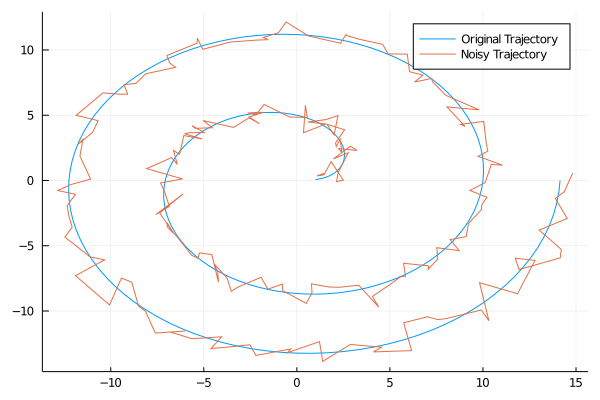

In [4]:
#Plots
plot(Mt[:,1],Mt[:,2], label="Original Trajectory")
plot!(Mt_noisy[:,1],Mt_noisy[:,2], label="Noisy Trajectory")

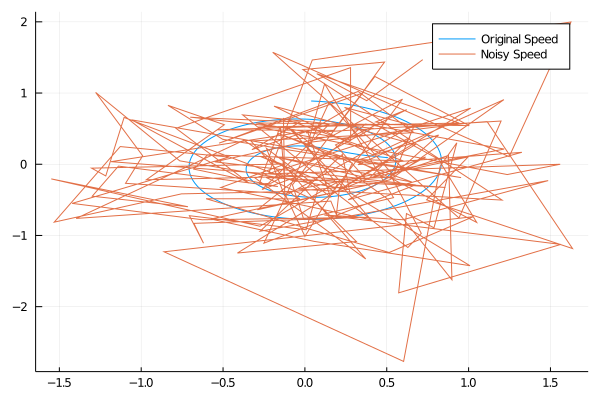

In [5]:
#Plots
plot(Vt[:,1], Vt[:,2], label="Original Speed")
plot!(Vt_noisy[:,1], Vt_noisy[:,2], label="Noisy Speed")

###  2) Expressions of ${\bf F}$ and ${\bf H}$ and expressions of the matrices ${\bf D}_Q$ and ${\bf D}_R$ in covariance matrices ${\bf Q}=cov[{\bf G} v_t]=σ_v^2 {\bf D}_Q$ and ${\bf R}=cov[{\bf U} n_t]=σ_n^2 {\bf D}_R$;

In [6]:
# Storage
#--------

σ_v = 0.01
δ = 1
ρ = 0.5
I_2 = [1 0; 0 1]
O_2 = [0 0; 0 0]
F = [I_2 δ.*I_2 O_2; O_2 I_2 δ.*I_2; O_2 O_2 ρ.*I_2];
G = [O_2; O_2; I_2];
H = [I_2 O_2 O_2; O_2 I_2 O_2];
U = Matrix{Float64}(I, 4, 4);
Q = σ_v^2 .* I_2;
R =σ_noise^2 .* Matrix{Float64}(I, 4, 4);

### 3) Implementation of the Kalman filter. We denote by  ${\bf K}$, ${\bf P}\_$ and ${\bf P}$ the Kalman gain, and covariance matrices of prediction and filtering errors respectively.


In [7]:
function kalman_filter(Y, X_filtered, P)
    X_predicted = F*X_filtered
    P_ = F*P*F'+G*Q*G'
    K = P_*H'*inv(H*P_*H'+U*R*U')
    X_filtered = X_predicted + K*(Y-H*X_predicted)
    P = P_ - K*H*P_
    return X_filtered,X_predicted,P, P_
end

kalman_filter (generic function with 1 method)

In [8]:
# Filtering
#----------

Mt_kalman = zeros(T,2)
Vt_kalman = zeros(T,2)
X_filtered = zeros(6,1)
X_filtered_kalman = zeros(T,6)
X_predicted_kalman = zeros(T,6)
P_kalman = zeros(T,6,6)
P__kalman = zeros(T,6,6)
P = Matrix{Float64}(I, 6, 6)
for i in 1:size(Mt_noisy)[1]
    Y = vcat(Mt_noisy[i,:], Vt_noisy[i,:])
    X_filtered,X_predicted,P, P_= kalman_filter(Y, X_filtered, P)
    Mt_kalman[i,:] = X_filtered[1:2]
    Vt_kalman[i,:] = X_filtered[3:4]
    
    # We keep these data for the smoother
    X_filtered_kalman[i,:] = X_filtered 
    X_predicted_kalman[i,:] = X_predicted
    P_kalman[i,:,:] = P
    P__kalman[i,:,:] = P_
end

### 4) Trajectories of position and speed estimated using the Kalman filter.

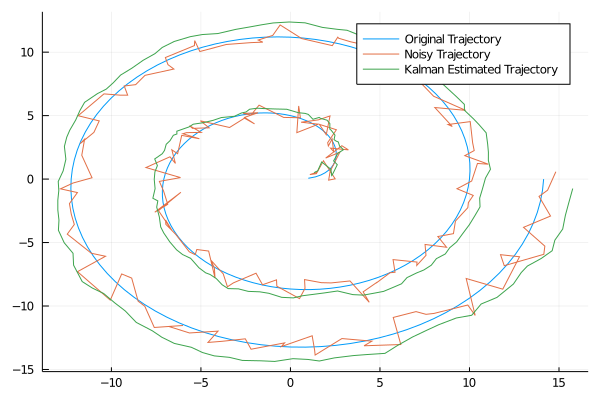

In [9]:
# Plots
#----------
#Plots

plot(Mt[:,1],Mt[:,2], label="Original Trajectory")
plot!(Mt_noisy[:,1],Mt_noisy[:,2], label="Noisy Trajectory")
plot!(Mt_kalman[:,1],Mt_kalman[:,2], label="Kalman Estimated Trajectory")

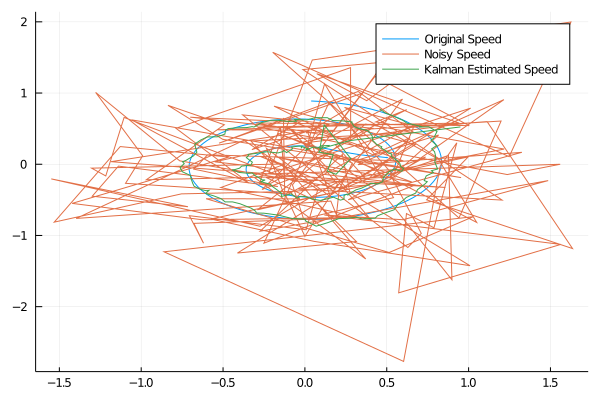

In [10]:
plot(Vt[:,1], Vt[:,2], label="Original Speed")
plot!(Vt_noisy[:,1], Vt_noisy[:,2], label="Noisy Speed")
plot!(Vt_kalman[:,1], Vt_kalman[:,2], label="Kalman Estimated Speed")

- When we increase the SNR on the original signal (we reduce the noise) the Kalman filter provide better estimate of the position and the speed.
- When we reduce the variance of the accelaration parameter σ_v, we notice a huge improvement on the estimates with Kalman Filter.

### 5) Kalman smoother improvment brought compared to the Kalman filter.

In [11]:
# Smoothing
#----------

function kalman_smoother(X_filtered, X_smoothed, P, P_, P_T)
    #backward gain
    K_b = P*F'*inv(P_)
    
    #New covariance matrix
    P_T = P-K_b*(P_T-P_)*K_b
    
    X_predicted = F*X_filtered
    
    
    #new estimate
    X_smoothed = X_filtered + K_b*(X_smoothed-X_predicted)
    return X_smoothed, P_T
end

kalman_smoother (generic function with 1 method)

In [12]:
X_smoothed = X_predicted_kalman[200,:]
Mt_kalman_smoother = zeros(T,2);
Vt_kalman_smoother = zeros(T,2);
Mt_kalman_smoother[T,:] = X_smoothed[1:2]
Vt_kalman_smoother[T,:] = X_smoothed[3:4]
P_T = P_kalman[200,:,:]
for i in size(X_predicted_kalman)[1]-1:-1:1
    X_filtered = X_predicted_kalman[i,:]
    P_ = P__kalman[i+1,:,:]
    P_ = P__kalman[i,:,:]
    X_smoothed,P_T = kalman_smoother(X_filtered, X_smoothed, P, P_, P_T)
    Mt_kalman_smoother[i,:] = X_smoothed[1:2]
    Vt_kalman_smoother[i,:] = X_smoothed[3:4] 
end

### 6) Trajectories of position and speed estimated using the Kalman smoother.

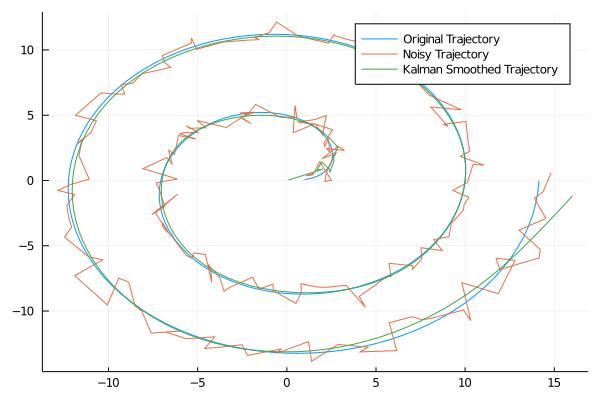

In [13]:
plot(Mt[:,1],Mt[:,2], label="Original Trajectory")
plot!(Mt_noisy[:,1],Mt_noisy[:,2], label="Noisy Trajectory")
plot!(Mt_kalman_smoother[:,1],Mt_kalman_smoother[:,2], label="Kalman Smoothed Trajectory")

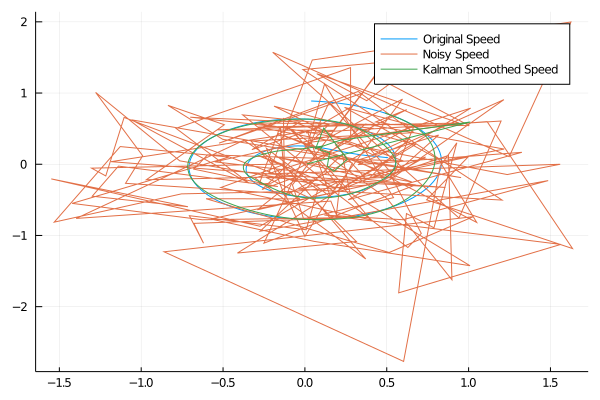

In [14]:
plot(Vt[:,1], Vt[:,2], label="Original Speed")
plot!(Vt_noisy[:,1], Vt_noisy[:,2], label="Noisy Speed")
plot!(Vt_kalman_smoother[:,1], Vt_kalman_smoother[:,2], label="Kalman Smoothed Speed")

### 7) Trajectories of position and speed estimated using the Kalman filter and Kalman smoother.

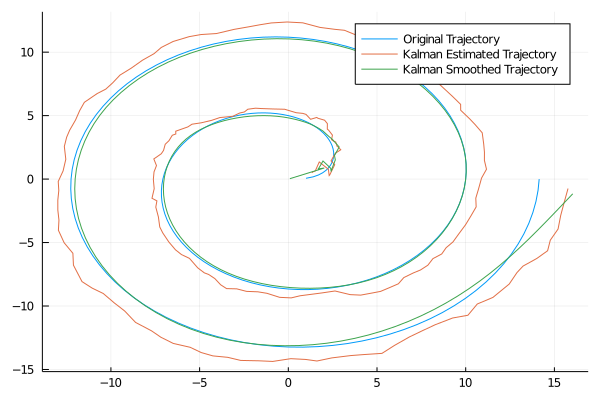

In [15]:
plot(Mt[:,1],Mt[:,2], label="Original Trajectory")
plot!(Mt_kalman[:,1],Mt_kalman[:,2], label="Kalman Estimated Trajectory")
plot!(Mt_kalman_smoother[:,1],Mt_kalman_smoother[:,2], label="Kalman Smoothed Trajectory")

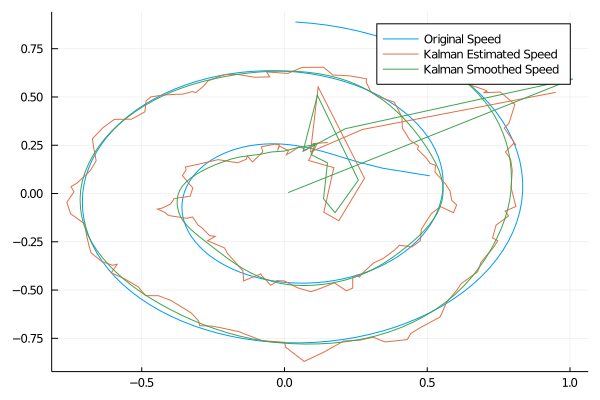

In [16]:
plot(Vt[:,1],Vt[:,2], label="Original Speed")
plot!(Vt_kalman[:,1],Vt_kalman[:,2], label="Kalman Estimated Speed")
plot!(Vt_kalman_smoother[:,1],Vt_kalman_smoother[:,2], label="Kalman Smoothed Speed")

- We obviously notice that the estimation of the trajectory and the speed are improved with the smoothing.

# <span style="color:#00B8DE">II - Particle filtering </span>

We consider the following nonlinear system:

$$
\begin{array}{lll}
{\text{state: }} &x_{t+1} &= 0.5 x_t + \dfrac{25x_t}{1+x_t^2}+8\cos(1,2t)+ v_t,\\
{\text{observation: }} &y_t &= 0.05 x_t^2+ w_t,
\end{array}
$$

with $v_t$ and $w_t$ having respective distributions $\mathcal{N}(0,0.1)$ and $\mathcal{N}(0,1)$.
We want to estimate recursively the state of the system by using a bootstrap particle filter.
We shall use 100 particles and choose $N_{eff}=90$.

###  1) Let's generate a trajectory of $y$ for $t=1:T$ with $T=100$.

In [17]:
#-----------------------------
# 1) Data model and generation

T = 100
t  = 1:T
σ_v = sqrt(0.1)
σ_w = 1
v = σ_v*randn(T)
w = σ_w*randn(T)
x_0 = 0
y = zeros(T)
x = zeros(T)

function next_x(x_t,v_t,t)
    return 0.5*x_t+25*x_t/(1+x_t^2)+8*cos(1.2*t)+v_t
end

x_t = x_0
for i in 1:size(w)[1]
    v_t = v[i]
    t = i
    x_t = next_x(x_t,v_t,t)
    x[i] = x_t
    y[i] = 0.05*x_t^2+w[i]
end

### 2) Plots of the trajectories of $y$ and $x$.

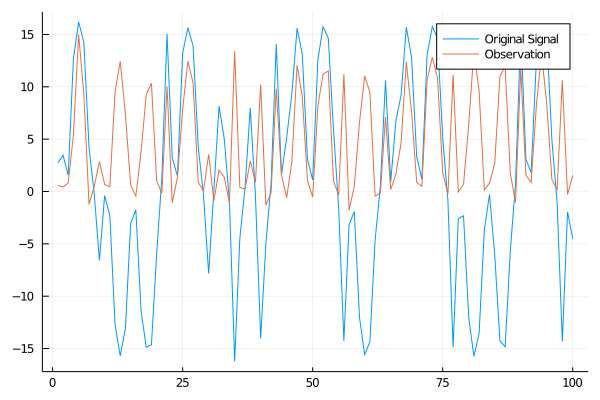

In [18]:
# Graphic outputs
#----------------

plot(x, label="Original Signal")
plot!(y, label="Observation")

- There is a significant difference between the state signal and the observation signal. The observation signal almost do not cross the horizontal axis whereas the state signal does.

- The difficulty of estimating x from y is in the sense that the system followed by the state is nonlinear.

### 3) Particle Sampling

In [19]:
#--------------------------
# 2) Particle sampling
#--------------------------
# Particles initialization
#--------------------------
N=10^3
Pa = zeros(T+1,N) #Particles Matrix Initialization
Pa[1,:] = randn(N) #randn(N) #Initialization of the initial state
Wg = (1/N)*ones(N); #Weights Matrix Initialization
Est_State = zeros(T);

In [20]:
function probability_function(μ,σ,x)
    fact1 = 1/sqrt(2*π*σ^2)
    cr = (x-μ)/σ
    fact2 = exp(-0.5*cr^2)
    return fact1*fact2
end

probability_function (generic function with 1 method)

In [21]:
#--------------------------
# Particle sampling
#--------------------------
resampling_number = 1

#Boostrap
for t in 2:T+1
    v_i = σ_v*randn(N)
    
    #Simulating a potential path - Prediction
    x_ = 0.5 .* Pa[t-1,:] .+ 25 .*Pa[t-1,:] ./ (1 .+ Pa[t-1,:].^2) .+ 8*cos(1.2*(t-1)) .+ v_i
    
    #Calculating and normalizing weights
    μ = 0.05*x_.^2
    σ = σ_w*ones(N)
    Wg = probability_function.(μ,σ,y[t-1]).*Wg
    Wg = Wg./sum(Wg) 
    
    #Resampling

    #Degeneracy Test
    Neff = 1/sum(Wg.^2)
    
    if Neff < 0.9*N
        println("Re-Sampling Number ",resampling_number)
        resampling_number += 1
        #Filtering
        Pa[t,:] = wsample(x_, Wg, N)
        Wg = (1/N)*ones(N); #Weights Matrix Initialization
    else
        Pa[t,:] = x_
    end    
    Est_State[t-1] = sum(Pa[t,:].*Wg)
    
end


Re-Sampling Number 1
Re-Sampling Number 2
Re-Sampling Number 3
Re-Sampling Number 4
Re-Sampling Number 5
Re-Sampling Number 6
Re-Sampling Number 7
Re-Sampling Number 8
Re-Sampling Number 9
Re-Sampling Number 10
Re-Sampling Number 11
Re-Sampling Number 12
Re-Sampling Number 13
Re-Sampling Number 14
Re-Sampling Number 15
Re-Sampling Number 16
Re-Sampling Number 17
Re-Sampling Number 18
Re-Sampling Number 19
Re-Sampling Number 20
Re-Sampling Number 21
Re-Sampling Number 22
Re-Sampling Number 23
Re-Sampling Number 24
Re-Sampling Number 25
Re-Sampling Number 26
Re-Sampling Number 27
Re-Sampling Number 28
Re-Sampling Number 29
Re-Sampling Number 30
Re-Sampling Number 31
Re-Sampling Number 32
Re-Sampling Number 33
Re-Sampling Number 34
Re-Sampling Number 35
Re-Sampling Number 36
Re-Sampling Number 37
Re-Sampling Number 38
Re-Sampling Number 39
Re-Sampling Number 40
Re-Sampling Number 41
Re-Sampling Number 42
Re-Sampling Number 43
Re-Sampling Number 44
Re-Sampling Number 45
Re-Sampling Number 

### 4) Results 

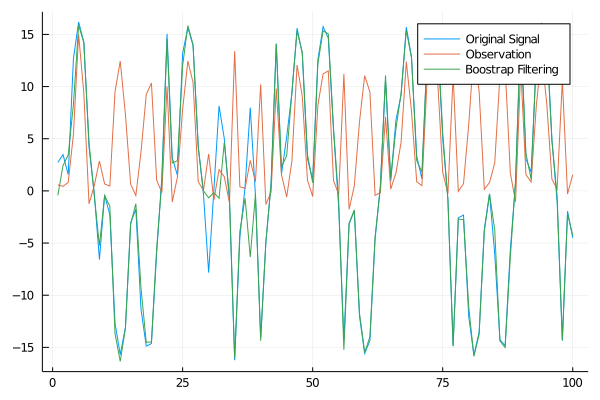

In [22]:
#--------------------------
# Graphic output
#--------------------------

plot(x, label="Original Signal")
plot!(y, label="Observation")
plot!(Est_State, label="Boostrap Filtering")

- The resampling rate seems to be 50% ==> That means we resample the state data every approximately after every half of data !

### 5) What occurs as the state noise variance increases ?

In [23]:
# --------------------------
# 3) If we increase the state noise variance
#--------------------------
σ_v = sqrt(1)
v = σ_v*randn(T)

x = zeros(T)

function next_x(x_t,v_t,t)
    return 0.5*x_t+25*x_t/(1+x_t^2)+8*cos(1.2*t)+v_t
end

x_t = x_0
for i in 1:size(w)[1]
    v_t = v[i]
    t = i
    x_t = next_x(x_t,v_t,t)
    x[i] = x_t
end

In [24]:
# Particles initialization
#--------------------------
N=10^3
Pa = zeros(T+1,N) #Particles Matrix Initialization
Pa[1,:] = randn(N) #randn(N) #Initialization of the initial state
Wg = (1/N)*ones(N); #Weights Matrix Initialization
Est_State = zeros(T);

In [25]:
#--------------------------
# Particle sampling
#--------------------------
resampling_number = 1

#Boostrap
for t in 2:T+1
    v_i = σ_v*randn(N)
    
    #Simulating a potential path - Prediction
    x_ = 0.5 .* Pa[t-1,:] .+ 25 .*Pa[t-1,:] ./ (1 .+ Pa[t-1,:].^2) .+ 8*cos(1.2*(t-1)) .+ v_i
    
    #Calculating and normalizing weights
    μ = 0.05*x_.^2
    σ = σ_w*ones(N)
    Wg = probability_function.(μ,σ,y[t-1]).*Wg
    Wg = Wg./sum(Wg) 
    
    #Resampling

    #Degeneracy Test
    Neff = 1/sum(Wg.^2)
    
    if Neff < 0.9*N
        #println("Re-Sampling Number ",resampling_number)
        resampling_number += 1
        #Filtering
        Pa[t,:] = wsample(x_, Wg, N)
        Wg = (1/N)*ones(N); #Weights Matrix Initialization
    else
        Pa[t,:] = x_
    end    
    Est_State[t-1] = sum(Pa[t,:].*Wg)
    
end


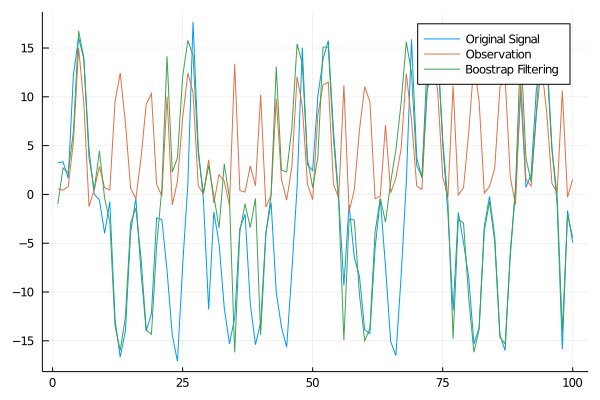

In [26]:
#--------------------------
# Graphic output
#--------------------------

plot(x, label="Original Signal")
plot!(y, label="Observation")
plot!(Est_State, label="Boostrap Filtering")

- When we increase the state noise variance the boostraping filtering performance decreases consequently !
- This is surely due to the fact that with a high variance, the state system is less stable and therefore it will be difficult to retrieve an accurate estimate of the expectation we are looking for.

----------